In [1]:
%load_ext autoreload
%autoreload 2
from corti.bezier_multirotor_planning import derive_bezier7, derive_bezier3
from corti.TimeOptBez import find_opt_multirotor_time

import numpy as np

from cyecca.models.bezier import derive_ref, derive_eulerB321_to_quat, derive_multirotor
from cyecca.lie import SO3EulerB321, SO3Quat
import casadi as ca
from cyecca.models.rdd2 import (
    derive_position_control,
    derive_attitude_control,
    derive_attitude_rate_control,
)
from cyecca.models.rdd2_loglinear import derive_se23_error, derive_outerloop_control
from cyecca.models.rdd2 import derive_control_allocation
from cyecca.models.quadrotor import derive_model, sim

python:  /home/lylin/cognipilot/cranium/src/cyecca/.venv/bin/python
python:  /home/lylin/cognipilot/cranium/src/cyecca/.venv/bin/python


In [2]:
bezier7 = derive_bezier7()
bezier3 = derive_bezier3()

# bezier boundary conditions
bc_t = np.array(
    [
        [  # position
            [0, 0, 0],  # wp0, x, y, z
            [0, 0, 2],  # wp0, x, y, z
            [0, -5, 2],
            [5, -5, 2],
            [5, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
        ],
        [  # velocity
            [0, 0, 0],  # wp0, x, y, z
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
        [  # accel
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],  # wp0, x, y, z
        ],
        [  # jerk
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],  # wp0, x, y, z
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
    ]
)
bc_psi_list = np.array(
    [
        [  # attitude
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
        [  # angular velocity
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
    ]
)

# solve for bezier trajectories
k = 10
T0_list = []
PX_list = []
PY_list = []
PZ_list = []
Ppsi_list = []
for i in range(bc_t.shape[1] - 1):
    bc = bc_t[:, i : i + 2, :]
    bc_psi = bc_psi_list[:, i : i + 2, :]
    T0 = 20  # find_opt_multirotor_time(8, 4, bc, bc_psi, k, 1)[0]
    PX = np.array(bezier7["bezier7_solve"](bc[:, 0, 0], bc[:, 1, 0], T0)).reshape(-1)
    PY = np.array(bezier7["bezier7_solve"](bc[:, 0, 1], bc[:, 1, 1], T0)).reshape(-1)
    PZ = np.array(bezier7["bezier7_solve"](bc[:, 0, 2], bc[:, 1, 2], T0)).reshape(-1)
    Ppsi = np.array(
        bezier3["bezier3_solve"](bc_psi[:, 0, 2], bc_psi[:, 1, 2], T0)
    ).reshape(-1)
    T0_list.append(T0)
    PX_list.append(PX)
    PY_list.append(PY)
    PZ_list.append(PZ)
    Ppsi_list.append(Ppsi)

# generate trajectory
x_list = []
y_list = []
z_list = []
vx_list = []
vy_list = []
vz_list = []
ax_list = []
ay_list = []
az_list = []
jx_list = []
jy_list = []
jz_list = []
sx_list = []
sy_list = []
sz_list = []
psi_list = []
dpsi_list = []
ddpsi_list = []
t_list = []
for leg in range(len(T0_list)):
    n_t = 100
    t_leg = np.array([np.arange(0, T0_list[leg], 1e-2)])
    traj_x = np.array(bezier7["bezier7_traj"](t_leg, T0_list[leg], PX_list[leg])).T
    traj_y = np.array(bezier7["bezier7_traj"](t_leg, T0_list[leg], PY_list[leg])).T
    traj_z = np.array(bezier7["bezier7_traj"](t_leg, T0_list[leg], PZ_list[leg])).T
    traj_psi = np.array(bezier3["bezier3_traj"](t_leg, T0_list[leg], Ppsi_list[leg])).T
    x = traj_x[:, 0]
    y = traj_y[:, 0]
    z = traj_z[:, 0]
    vx = traj_x[:, 1]
    vy = traj_y[:, 1]
    vz = traj_z[:, 1]
    ax = traj_x[:, 2]
    ay = traj_y[:, 2]
    az = traj_z[:, 2]
    jx = traj_x[:, 3]
    jy = traj_y[:, 3]
    jz = traj_z[:, 3]
    sx = traj_x[:, 4]
    sy = traj_y[:, 4]
    sz = traj_z[:, 4]
    psi = traj_psi[:, 0]
    dpsi = traj_psi[:, 1]
    ddpsi = traj_psi[:, 2]
    t = t_leg + leg * T0
    t_list.extend(t.reshape(-1))
    x_list.extend(x)
    y_list.extend(y)
    z_list.extend(z)
    vx_list.extend(vx)
    vy_list.extend(vy)
    vz_list.extend(vz)
    ax_list.extend(ax)
    ay_list.extend(ay)
    az_list.extend(az)
    jx_list.extend(jx)
    jy_list.extend(jy)
    jz_list.extend(jz)
    sx_list.extend(sx)
    sy_list.extend(sy)
    sz_list.extend(sz)
    psi_list.extend(psi)
    dpsi_list.extend(dpsi)
    ddpsi_list.extend(ddpsi)

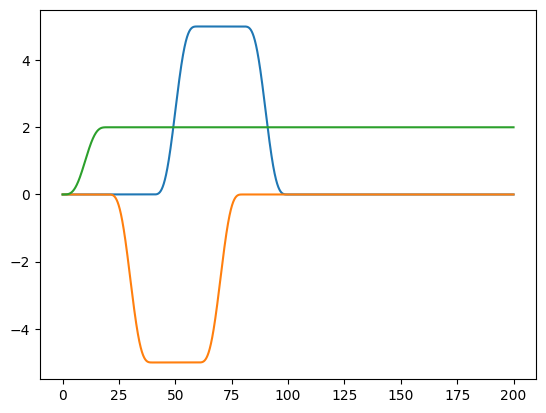

In [3]:
import matplotlib.pyplot as plt

plt.plot(t_list, x_list)
plt.plot(t_list, y_list)
plt.plot(t_list, z_list)
# plt.gca().set_xlim([0,10])
# plt.gca().set_ylim([,0.005])

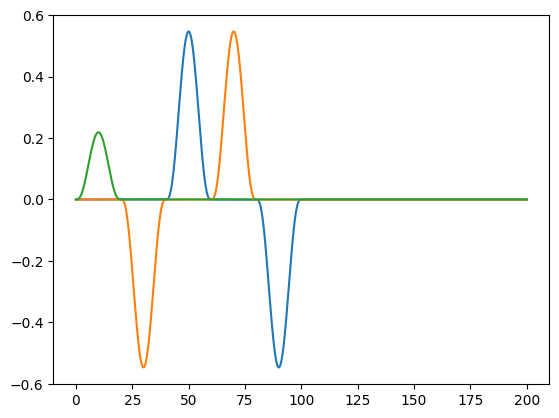

In [4]:
plt.plot(t_list, vx_list)
# plt.plot(np.diff(np.array(x_list), axis=0)/0.1)
plt.plot(t_list, vy_list)
# plt.plot(np.diff(np.array(y_list), axis=0)/0.1)
plt.plot(t_list, vz_list)
# plt.plot(np.diff(np.array(z_list), axis=0)/0.1)

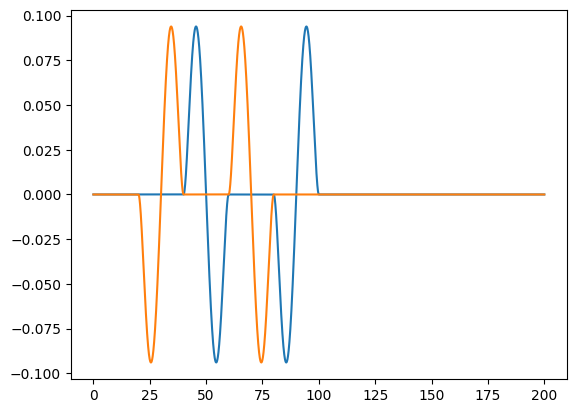

In [5]:
plt.plot(t_list, ax_list)
# plt.plot(np.diff(np.array(vx_list), axis=0)/0.1)
plt.plot(t_list, ay_list)
# plt.plot(np.diff(np.array(vy_list), axis=0)/0.1)
# plt.plot(az_list)
# plt.plot(np.diff(np.array(vz_list), axis=0)/0.1)

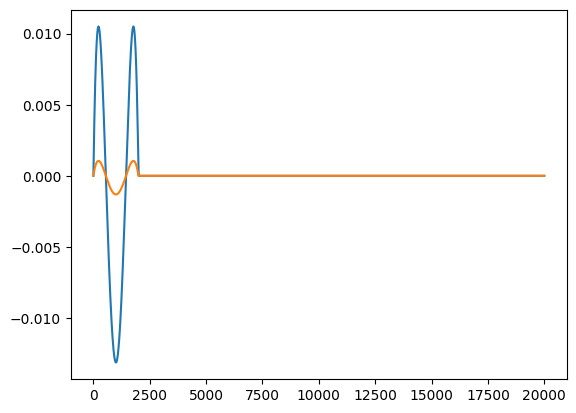

In [6]:
# plt.plot(jx_list)
# plt.plot(np.diff(np.array(ax_list), axis=0)/0.1)
# plt.plot(jy_list)
# plt.plot(np.diff(np.array(ay_list), axis=0)/0.1)
plt.plot(jz_list)
plt.plot(np.diff(np.array(az_list), axis=0) / 0.1)

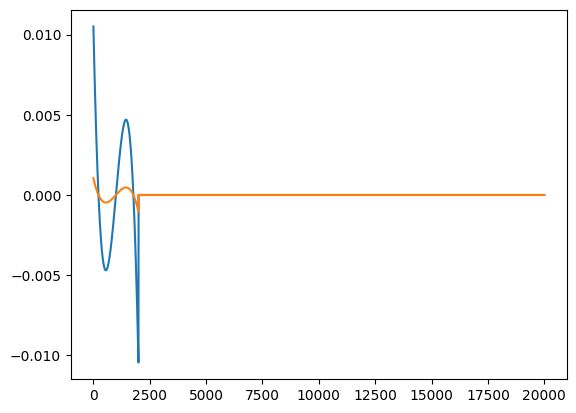

In [7]:
# plt.plot(sx_list)
# plt.plot(np.diff(np.array(jx_list), axis=0)/0.1)
# plt.plot(sy_list)
# plt.plot(np.diff(np.array(jy_list), axis=0)/0.1)
plt.plot(sz_list)
plt.plot(np.diff(np.array(jz_list), axis=0) / 0.1)

In [8]:
f_ref = derive_ref()["f_ref"]
vb_list = []
euler_list = []
omega_list = []
omega_dot_list = []
M_list = []
T_list = []
for i in range(len(x_list)):
    ref = f_ref(
        psi_list[i],
        dpsi_list[i],
        ddpsi_list[i],
        np.array([vx_list[i], vy_list[i], vz_list[i]]),
        np.array([ax_list[i], ay_list[i], az_list[i]]),
        np.array([jx_list[i], jy_list[i], jz_list[i]]),
        np.array([sx_list[i], sy_list[i], sz_list[i]]),
    )
    vb = ref[0]
    quat = ref[1]
    omega = np.array(ref[2]).reshape(-1)
    domega = np.array(ref[3]).reshape(-1)
    M = np.array(ref[4]).reshape(-1)
    T = np.array(ref[5]).reshape(-1)
    euler = np.rad2deg(
        ca.DM(SO3EulerB321.from_Quat(SO3Quat.elem(ca.DM(quat))).param)
    ).reshape(-1)
    vb_list.append(vb)
    euler_list.append(euler)
    omega_list.append(omega)
    omega_dot_list.append(domega)
    M_list.append(M)
    T_list.append(T)

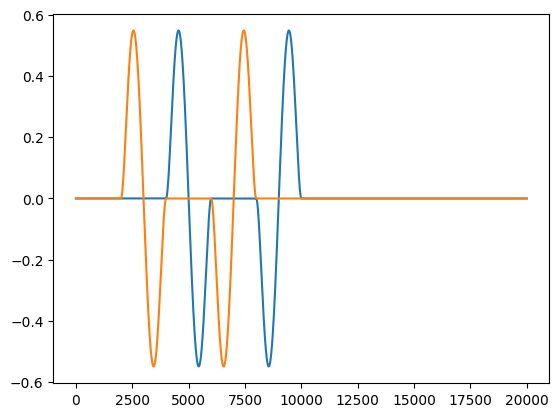

In [9]:
plt.plot(np.array(euler_list)[:, 1])
plt.plot(np.array(euler_list)[:, 2])

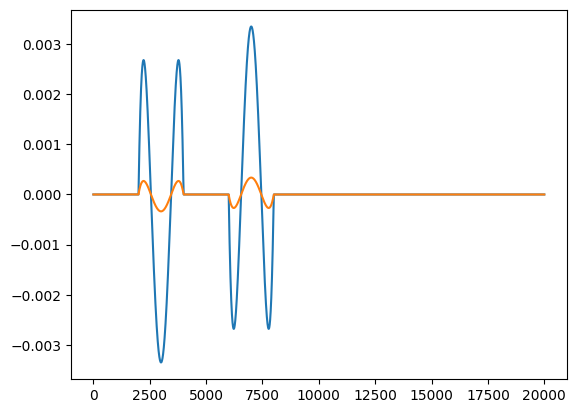

In [10]:
plt.plot(np.array(omega_list)[:, 0])
plt.plot(np.diff(np.array(euler_list), axis=0)[:, 2] / 0.1 / 57)
# plt.plot(np.array(omega_list)[:, 1])
# plt.plot(np.array(omega_list)[:, 2])

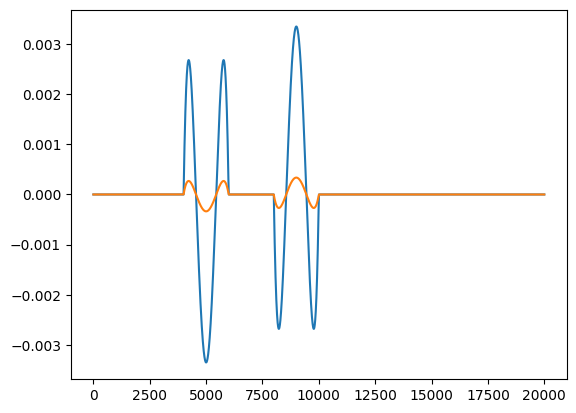

In [11]:
plt.plot(np.array(omega_list)[:, 1])
plt.plot(np.diff(np.array(euler_list), axis=0)[:, 1] / 0.1 / 57)

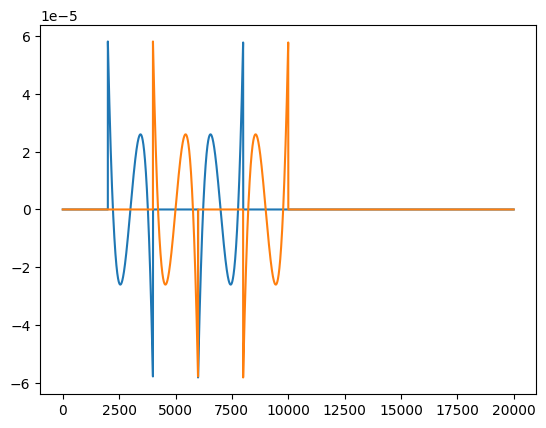

In [12]:
plt.plot(np.array(M_list)[:, 0])
plt.plot(np.array(M_list)[:, 1])
# plt.gca().set_xlim([100,125])
# plt.gca().set_ylim([-0.005,0.005])
# plt.plot(np.array(M_list)[:, 2])
# plt.plot(np.diff(np.array(omega_list), axis=0)[:, 1]/0.1)

In [13]:
f = derive_control_allocation()["f_alloc"]
f_euler_to_quat = derive_eulerB321_to_quat()["eulerB321_to_quat"]
f_pos_control = derive_position_control()["position_control"]
f_att_control = derive_attitude_control()["attitude_control"]
f_att_rate_control = derive_attitude_rate_control()["attitude_rate_control"]
f_multirotor = derive_multirotor()["bezier_multirotor"]
f_se23_error = derive_se23_error()["se23_error"]
f_se23_control = derive_outerloop_control()["se23_control"]
model = derive_model()

In [434]:
u_list = []
for i in range(len(T_list)):
    u, _, _, _, _ = f(100, 0.25 / ca.sqrt(2), 0.016, 8.54858e-06, T_list[i], M_list[i])
    u_list.append(np.array(u).reshape(-1))

In [395]:
model = derive_model()
x0_dict = model["x0_defaults"]
x0 = None
p = None
t = np.arange(0, t_list[-1] + 0.005, 0.01)
if x0 is not None:
    for k in x0.keys():
        if not k in x0_dict.keys():
            raise KeyError(k)
        x0_dict[k] = x0[k]
p_dict = model["p_defaults"]
if p is not None:
    for k in p.keys():
        if not k in p_dict.keys():
            raise KeyError(k)
        p_dict[k] = p[k]
dae = model["dae"]
f_int = ca.integrator("test", "idas", dae, t[0], t)
res = f_int(x0=x0_dict.values(), z0=0, p=p_dict.values(), u=np.array(u_list).T)
res["p"] = p_dict
# res["yf"] = model["g"](res["xf"], u, p_dict.values())

for k in ["xf", "zf"]:
    res[k] = np.array(res[k])

In [86]:
x0_dict = model["x0_defaults"]
x0 = None
p = None
if x0 is not None:
    for k in x0.keys():
        if not k in x0_dict.keys():
            raise KeyError(k)
        x0_dict[k] = x0[k]
p_dict = model["p_defaults"]
if p is not None:
    for k in p.keys():
        if not k in p_dict.keys():
            raise KeyError(k)
        p_dict[k] = p[k]
x = np.array(list(x0_dict.values()), dtype=float)
p = np.array(list(p_dict.values()), dtype=float)
u = np.zeros(4, dtype=float)
t1 = 0
dt = 1e-2
k_p_att = np.array([5, 5, 2], dtype=float)
leg = 0
CT = 8.54858e-06

thrust_trim = 2 * 9.8
# attitude rate
kp = np.array([0.3, 0.3, 0.05], dtype=float)
ki = np.array([0, 0, 0], dtype=float)
kd = np.array([0.1, 0.1, 0], dtype=float)
i0 = 0
e0 = np.zeros(3, dtype=float)  # error for attitude rate loop
de0 = np.zeros(3, dtype=float)  # deriv of att error (for lowpass)
f_cut = 10.0
i_max = np.array([0, 0, 0], dtype=float)
dae = model["dae"]
z_i = 0
pos_list = []
u_alloc_list = []
M_ff_list = []
thrust_ff_list = []
x_sp_list = []
y_sp_list = []
z_sp_list = []
v_sp_list = []
a_sp_list = []
j_sp_list = []
s_sp_list = []
motor_omega_list = []
t1_list = []
for i in range(len(t_list)):
    t = t_list[i]  # + 1e-11*np.random.randn()
    if t > T0 * (leg + 1):
        leg += 1
    t_bezier = t - T0 * leg - dt / 2
    pw = np.array(
        [
            x[model["x_index"]["position_op_w_0"]],
            x[model["x_index"]["position_op_w_1"]],
            x[model["x_index"]["position_op_w_2"]],
        ]
    )
    vw = np.array(
        [
            x[model["x_index"]["velocity_w_p_b_0"]],
            x[model["x_index"]["velocity_w_p_b_1"]],
            x[model["x_index"]["velocity_w_p_b_2"]],
        ]
    )
    q = np.array(
        [
            x[model["x_index"]["quaternion_wb_0"]],
            x[model["x_index"]["quaternion_wb_1"]],
            x[model["x_index"]["quaternion_wb_2"]],
            x[model["x_index"]["quaternion_wb_3"]],
        ]
    )
    omega = np.array(
        [
            x[model["x_index"]["omega_wb_b_0"]],
            x[model["x_index"]["omega_wb_b_1"]],
            x[model["x_index"]["omega_wb_b_2"]],
        ]
    )
    [
        x_sp,
        y_sp,
        z_sp,
        psi_sp,
        dpsi_sp,
        ddpsi_sp,
        vw_sp,
        aw_sp,
        jw_sp,
        sw_sp,
    ] = f_multirotor(
        t_bezier, T0, PX_list[leg], PY_list[leg], PZ_list[leg], Ppsi_list[leg]
    )
    [_, q_sp, omega_ff, _, M_ff, thrust_ff] = f_ref(
        psi_sp, dpsi_sp, ddpsi_sp, vw_sp, aw_sp, jw_sp, sw_sp
    )
    u, Fp, Fm, Ft, Msat = f(100, 0.25 / ca.sqrt(2), 0.016, CT, thrust_ff, M_ff)

    try:
        f_int = ca.integrator("test", "idas", dae, t, t + dt)
        res = f_int(x0=x, z0=0, p=p, u=u)
    except RuntimeError as e:
        print(e)
        xdot = model["f"](x=x, u=u, p=p)
        print(xdot, x, u, p)
        raise e
    # print(i ,u)
    x = np.array(res["xf"]).reshape(-1)
    t1_list.append(t1)
    t1 += dt
    res["p"] = p_dict
    pos = x[0:3]
    motor_omega = x[13:]
    x_sp_list.append(np.array(x_sp).reshape(-1))
    y_sp_list.append(np.array(y_sp).reshape(-1))
    z_sp_list.append(np.array(z_sp).reshape(-1))
    v_sp_list.append(np.array(vw_sp).reshape(-1))
    a_sp_list.append(np.array(aw_sp).reshape(-1))
    j_sp_list.append(np.array(jw_sp).reshape(-1))
    s_sp_list.append(np.array(sw_sp).reshape(-1))
    pos_list.append(np.array(pos).reshape(-1))
    u_alloc_list.append(np.array(u).reshape(-1))
    motor_omega_list.append(np.array(motor_omega).reshape(-1))
    M_ff_list.append(np.array(M_ff).reshape(-1))
    thrust_ff_list.append(np.array(thrust_ff).reshape(-1))

In [117]:
# loglinear
model = derive_model()
x0_dict = model["x0_defaults"]
x0 = None
p = None
if x0 is not None:
    for k in x0.keys():
        if not k in x0_dict.keys():
            raise KeyError(k)
        x0_dict[k] = x0[k]
p_dict = model["p_defaults"]
if p is not None:
    for k in p.keys():
        if not k in p_dict.keys():
            raise KeyError(k)
        p_dict[k] = p[k]
x = np.array(list(x0_dict.values()), dtype=float)
p = np.array(list(p_dict.values()), dtype=float)
u = np.zeros(4, dtype=float)
t1 = 0
dt = 0.01
k_p_att = np.array([5, 5, 2], dtype=float)
leg = 0

thrust_trim = 2 * 9.8
# attitude rate
kp = np.array([0.3, 0.3, 0.05], dtype=float)
ki = np.array([0, 0, 0], dtype=float)
kd = np.array([0.0, 0.0, 0], dtype=float)
i0 = 0
e0 = np.zeros(3, dtype=float)  # error for attitude rate loop
de0 = np.zeros(3, dtype=float)  # deriv of att error (for lowpass)
f_cut = 10.0
i_max = np.array([0, 0, 0], dtype=float)
dae = model["dae"]
z_i = 0
pos_list = []
u_alloc_list = []
M_ff_list = []
thrust_ff_list = []
x_sp_list = []
y_sp_list = []
z_sp_list = []
v_sp_list = []
a_sp_list = []
j_sp_list = []
s_sp_list = []
motor_omega_list = []
t1_list = []
for i in range(len(t_list)):
    t = t_list[i]
    if t > T0 * (leg + 1):
        leg += 1
    t_bezier = t - T0 * leg - dt / 2
    pw = np.array(
        [
            x[model["x_index"]["position_op_w_0"]],
            x[model["x_index"]["position_op_w_1"]],
            x[model["x_index"]["position_op_w_2"]],
        ]
    )
    vw = np.array(
        [
            x[model["x_index"]["velocity_w_p_b_0"]],
            x[model["x_index"]["velocity_w_p_b_1"]],
            x[model["x_index"]["velocity_w_p_b_2"]],
        ]
    )
    q = np.array(
        [
            x[model["x_index"]["quaternion_wb_0"]],
            x[model["x_index"]["quaternion_wb_1"]],
            x[model["x_index"]["quaternion_wb_2"]],
            x[model["x_index"]["quaternion_wb_3"]],
        ]
    )
    omega = np.array(
        [
            x[model["x_index"]["omega_wb_b_0"]],
            x[model["x_index"]["omega_wb_b_1"]],
            x[model["x_index"]["omega_wb_b_2"]],
        ]
    )
    [
        x_sp,
        y_sp,
        z_sp,
        psi_sp,
        dpsi_sp,
        ddpsi_sp,
        vw_sp,
        aw_sp,
        jw_sp,
        sw_sp,
    ] = f_multirotor(
        t_bezier, T0, PX_list[leg], PY_list[leg], PZ_list[leg], Ppsi_list[leg]
    )
    [_, q_sp, omega_ff, _, M_ff, thrust_ff] = f_ref(
        psi_sp, dpsi_sp, ddpsi_sp, vw_sp, aw_sp, jw_sp, sw_sp
    )
    qc_sp = f_euler_to_quat(psi_sp, 0, 0)
    pw_sp = np.array([x_sp, y_sp, z_sp]).reshape(-1)
    zeta = f_se23_error(
        pw,
        vw,
        q,
        pw_sp,
        vw_sp,
        q_sp,
    )
    # position control: world frame
    [thrust, z_i, omega_fb, u_a] = f_se23_control(
        thrust_trim,
        k_p_att,
        zeta,
        aw_sp,
        q,
        z_i,
        dt,
    )
    omega_sp = omega_fb + omega_ff
    M_fb, i1, e1, de1, alpha = f_att_rate_control(
        kp,
        ki,
        kd,
        f_cut,
        i_max,
        omega,
        omega_sp,
        i0,
        e0,
        de0,
        dt,
    )
    i0 = i1
    e0 = e1
    de0 = de1
    M_sp = M_fb + M_ff
    u, Fp, Fm, Ft, Msat = f(100, 0.25 / ca.sqrt(2), 0.016, CT, thrust, M_sp)
    try:
        f_int = ca.integrator("test", "idas", dae, t, t + dt)
        res = f_int(x0=x, z0=0, p=p, u=u)
    except RuntimeError as e:
        print(e)
        xdot = model["f"](x=x, u=u, p=p)
        print(xdot, x, u, p)
        raise e
    t1 += dt
    x = np.array(res["xf"]).reshape(-1)
    res["p"] = p_dict
    pos = x[0:3]
    pos_list.append(np.array(pos).reshape(-1))
    u_alloc_list.append(np.array(u).reshape(-1))
    M_ff_list.append(np.array(M_ff).reshape(-1))
    thrust_ff_list.append(np.array(thrust_ff).reshape(-1))
# res["yf"] = model["g"](res["xf"], u, p_dict.values())

for k in ["xf", "zf"]:
    res[k] = np.array(res[k])

In [120]:
# mellinger
model = derive_model()
x0_dict = model["x0_defaults"]
x0 = None
p = None
if x0 is not None:
    for k in x0.keys():
        if not k in x0_dict.keys():
            raise KeyError(k)
        x0_dict[k] = x0[k]
p_dict = model["p_defaults"]
if p is not None:
    for k in p.keys():
        if not k in p_dict.keys():
            raise KeyError(k)
        p_dict[k] = p[k]
x = np.array(list(x0_dict.values()), dtype=float)
p = np.array(list(p_dict.values()), dtype=float)
u = np.zeros(4, dtype=float)
t1 = 0
dt = 0.01
k_p_att = np.array([5, 5, 2], dtype=float)
leg = 0

thrust_trim = 2 * 9.8
# attitude rate
kp = np.array([0.3, 0.3, 0.05], dtype=float)
ki = np.array([0, 0, 0], dtype=float)
kd = np.array([0.0, 0.0, 0], dtype=float)
i0 = 0
e0 = np.zeros(3, dtype=float)  # error for attitude rate loop
de0 = np.zeros(3, dtype=float)  # deriv of att error (for lowpass)
f_cut = 10.0
i_max = np.array([0, 0, 0], dtype=float)
dae = model["dae"]
z_i = 0
pos_list = []
u_alloc_list = []
M_ff_list = []
thrust_ff_list = []
x_sp_list = []
y_sp_list = []
z_sp_list = []
v_sp_list = []
a_sp_list = []
j_sp_list = []
s_sp_list = []
motor_omega_list = []
t1_list = []
for i in range(len(t_list)):
    t = t_list[i]
    if t > T0 * (leg + 1):
        leg += 1
    t_bezier = t - T0 * leg - dt / 2
    pw = np.array(
        [
            x[model["x_index"]["position_op_w_0"]],
            x[model["x_index"]["position_op_w_1"]],
            x[model["x_index"]["position_op_w_2"]],
        ]
    )
    vw = np.array(
        [
            x[model["x_index"]["velocity_w_p_b_0"]],
            x[model["x_index"]["velocity_w_p_b_1"]],
            x[model["x_index"]["velocity_w_p_b_2"]],
        ]
    )
    q = np.array(
        [
            x[model["x_index"]["quaternion_wb_0"]],
            x[model["x_index"]["quaternion_wb_1"]],
            x[model["x_index"]["quaternion_wb_2"]],
            x[model["x_index"]["quaternion_wb_3"]],
        ]
    )
    omega = np.array(
        [
            x[model["x_index"]["omega_wb_b_0"]],
            x[model["x_index"]["omega_wb_b_1"]],
            x[model["x_index"]["omega_wb_b_2"]],
        ]
    )
    [
        x_sp,
        y_sp,
        z_sp,
        psi_sp,
        dpsi_sp,
        ddpsi_sp,
        vw_sp,
        aw_sp,
        jw_sp,
        sw_sp,
    ] = f_multirotor(
        t_bezier, T0, PX_list[leg], PY_list[leg], PZ_list[leg], Ppsi_list[leg]
    )
    [_, q_sp, omega_ff, _, M_ff, thrust_ff] = f_ref(
        psi_sp, dpsi_sp, ddpsi_sp, vw_sp, aw_sp, jw_sp, sw_sp
    )
    qc_sp = f_euler_to_quat(psi_sp, 0, 0)
    pw_sp = np.array([x_sp, y_sp, z_sp]).reshape(-1)
    [thrust, q_sp, z_i] = f_pos_control(
        thrust_trim,
        pw_sp,
        vw_sp,
        aw_sp,
        qc_sp,
        pw,
        vw,
        z_i,
        dt,
    )
    omega_fb = f_att_control(k_p_att, q, q_sp)
    omega_sp = omega_fb + omega_ff
    M, i1, e1, de1, alpha = f_att_rate_control(
        kp,
        ki,
        kd,
        f_cut,
        i_max,
        omega,
        omega_sp,
        i0,
        e0,
        de0,
        dt,
    )
    i0 = i1
    e0 = e1
    de0 = de1
    M_sp = M + M_ff
    u, Fp, Fm, Ft, Msat = f(100, 0.25 / ca.sqrt(2), 0.016, CT, thrust, M_sp)
    print(
        i,
        thrust,
        M_sp,
    )
    print(u, Fp, Fm, Ft, Msat)
    try:
        f_int = ca.integrator("test", "idas", dae, t, t + dt)
        res = f_int(x0=x, z0=0, p=p, u=u)
    except RuntimeError as e:
        print(e)
        xdot = model["f"](x=x, u=u, p=p)
        print(xdot, x, u, p)
        raise e
    x = np.array(res["xf"]).reshape(-1)
    res["p"] = p_dict
    pos = x[0:3]
    pos_list.append(np.array(pos).reshape(-1))
    u_alloc_list.append(np.array(u).reshape(-1))
    M_ff_list.append(np.array(M_ff).reshape(-1))
    thrust_ff_list.append(np.array(thrust_ff).reshape(-1))
# res["yf"] = model["g"](res["xf"], u, p_dict.values())

for k in ["xf", "zf"]:
    res[k] = np.array(res[k])

0 19.6 [0, 0, 0]
[757.096, 757.096, 757.096, 757.096] [4.9, 4.9, 4.9, 4.9] [-0, 0, 0, 0] [4.9, 4.9, 4.9, 4.9] [0, 0, 0]
1 19.6 [5.14746e-66, 3.15158e-17, 8.80352e-50]
[757.096, 757.096, 757.096, 757.096] [4.9, 4.9, 4.9, 4.9] [-4.45701e-17, 4.45701e-17, -4.45701e-17, 4.45701e-17] [4.9, 4.9, 4.9, 4.9] [5.14746e-66, 3.15158e-17, 8.80352e-50]
2 19.6 [-2.81463e-65, 6.45843e-17, 2.31137e-49]
[757.096, 757.096, 757.096, 757.096] [4.9, 4.9, 4.9, 4.9] [-9.1336e-17, 9.1336e-17, -9.1336e-17, 9.1336e-17] [4.9, 4.9, 4.9, 4.9] [-2.81463e-65, 6.45843e-17, 2.31137e-49]
3 19.6 [-2.81817e-65, 9.92209e-17, 3.16821e-49]
[757.096, 757.096, 757.096, 757.096] [4.9, 4.9, 4.9, 4.9] [-1.4032e-16, 1.4032e-16, -1.4032e-16, 1.4032e-16] [4.9, 4.9, 4.9, 4.9] [-2.81817e-65, 9.92209e-17, 3.16821e-49]
4 19.6 [3.64799e-64, 1.35441e-16, 2.83943e-49]
[757.096, 757.096, 757.096, 757.096] [4.9, 4.9, 4.9, 4.9] [-1.91543e-16, 1.91543e-16, -1.91543e-16, 1.91543e-16] [4.9, 4.9, 4.9, 4.9] [3.64799e-64, 1.35441e-16, 2.83943e-49]


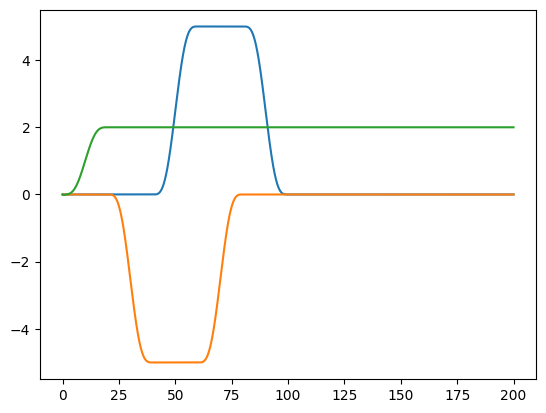

In [112]:
import matplotlib.pyplot as plt

t = np.arange(0, t_list[-1] + dt / 2, dt)
plt.plot(t, np.array(pos_list)[:, 0])
plt.plot(t, np.array(pos_list)[:, 1])
plt.plot(t, np.array(pos_list)[:, 2])

plt.plot(t_list, x_list)
plt.plot(t_list, y_list)
plt.plot(t, z_list)
# plt.legend(['z', 'zr'])

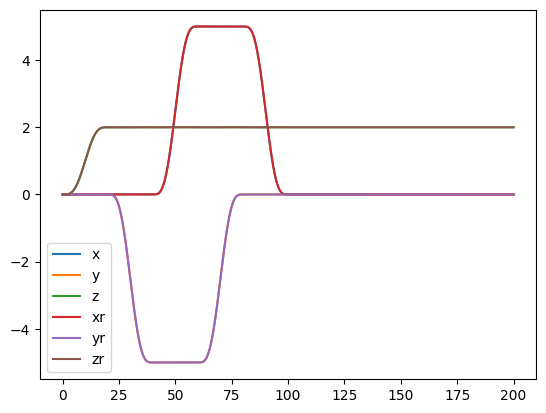

In [32]:
import matplotlib.pyplot as plt

t = np.arange(0, t_list[-1] + dt / 2, dt)
plt.plot(t, np.array(pos_list)[:, 0])
plt.plot(t, np.array(pos_list)[:, 1])
plt.plot(t, np.array(pos_list)[:, 2])

plt.plot(t_list, x_list)
plt.plot(t_list, y_list)
plt.plot(t, z_list)
plt.legend(["x", "y", "z", "xr", "yr", "zr"])

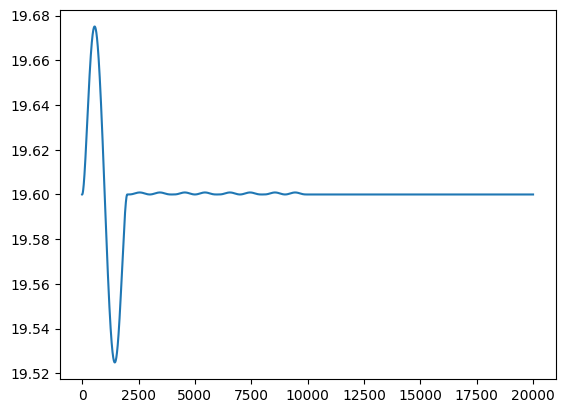

In [48]:
plt.plot(thrust_ff_list)

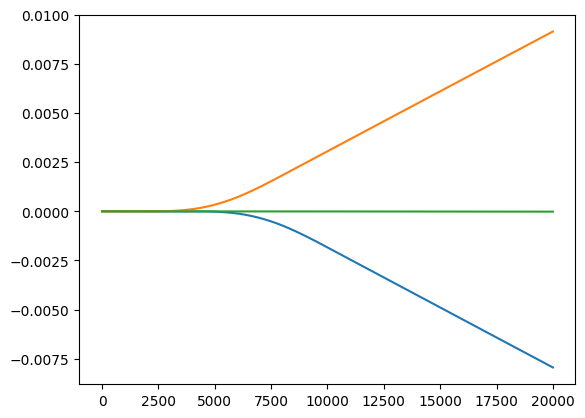

In [88]:
plt.plot(np.array(pos_list)[:, 0] - x_list)
plt.plot(np.array(pos_list)[:, 1] - y_list)
plt.plot(np.array(pos_list)[:, 2] - z_list)

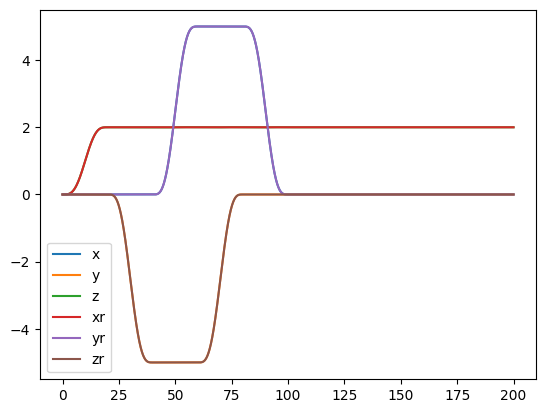

In [118]:
import matplotlib.pyplot as plt

t = np.arange(0, t_list[-1] + dt / 2, dt)
plt.plot(t, np.array(pos_list)[:, 0])
plt.plot(t, np.array(pos_list)[:, 1])
plt.plot(t, np.array(pos_list)[:, 2])

plt.plot(t, z_list)
plt.plot(t, x_list)
plt.plot(t, y_list)
plt.legend(["x", "y", "z", "xr", "yr", "zr"])

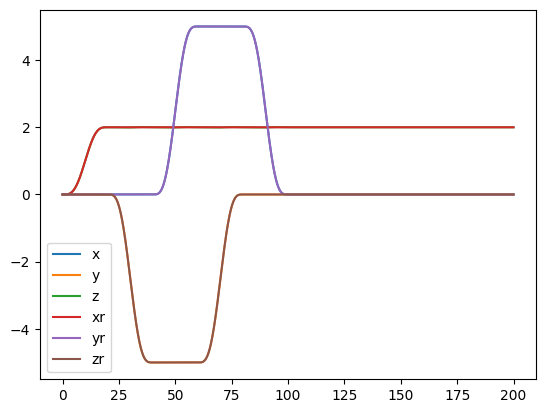

In [121]:
import matplotlib.pyplot as plt

t = np.arange(0, t_list[-1] + dt, dt)
plt.plot(t, np.array(pos_list)[:, 0])
plt.plot(t, np.array(pos_list)[:, 1])
plt.plot(t, np.array(pos_list)[:, 2])

plt.plot(t, z_list)
plt.plot(t, x_list)
plt.plot(t, y_list)
plt.legend(["x", "y", "z", "xr", "yr", "zr"])

0.10972378259385844
0.1178313810855671
0.17183843713116426


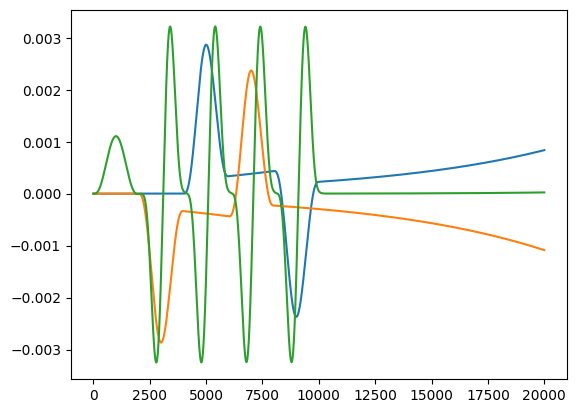

In [119]:
# loglinear
plt.plot(np.array(pos_list)[:, 0] - x_list)
plt.plot(np.array(pos_list)[:, 1] - y_list)
plt.plot(np.array(pos_list)[:, 2] - z_list)
print(np.linalg.norm(np.array(pos_list)[:, 0] - x_list))
print(np.linalg.norm(np.array(pos_list)[:, 1] - y_list))
print(np.linalg.norm(np.array(pos_list)[:, 2] - z_list))

0.10094296337646944
0.10093704915645986
0.329753648341968


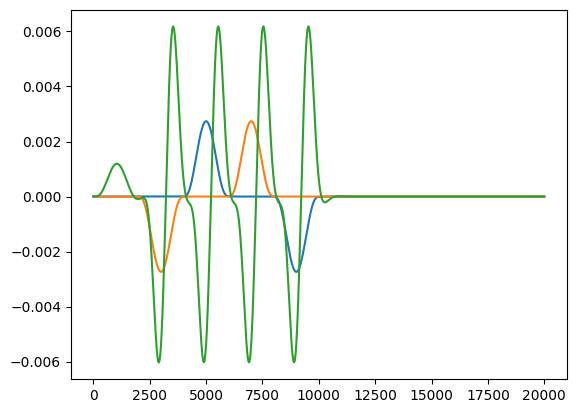

In [122]:
# mellinger
plt.plot(np.array(pos_list)[:, 0] - x_list)
plt.plot(np.array(pos_list)[:, 1] - y_list)
plt.plot(np.array(pos_list)[:, 2] - z_list)
print(np.linalg.norm(np.array(pos_list)[:, 0] - x_list))
print(np.linalg.norm(np.array(pos_list)[:, 1] - y_list))
print(np.linalg.norm(np.array(pos_list)[:, 2] - z_list))

In [20]:
model["x_index"]

{'position_op_w_0': 0,
 'position_op_w_1': 1,
 'position_op_w_2': 2,
 'velocity_w_p_b_0': 3,
 'velocity_w_p_b_1': 4,
 'velocity_w_p_b_2': 5,
 'quaternion_wb_0': 6,
 'quaternion_wb_1': 7,
 'quaternion_wb_2': 8,
 'quaternion_wb_3': 9,
 'omega_wb_b_0': 10,
 'omega_wb_b_1': 11,
 'omega_wb_b_2': 12,
 'omega_motor_0': 13,
 'omega_motor_1': 14,
 'omega_motor_2': 15,
 'omega_motor_3': 16}

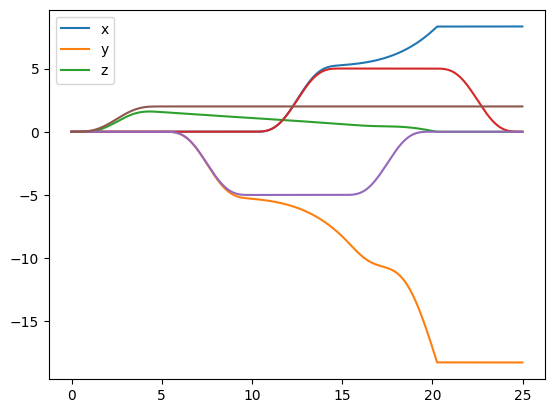

In [19]:
import matplotlib.pyplot as plt

plt.plot(t, res["xf"].T[:, 0:3])
plt.legend(["x", "y", "z"])
plt.plot(t_list, x_list)
plt.plot(t_list, y_list)
plt.plot(t_list, z_list)

# plt.gca().set_xlim([0,10])
# plt.gca().set_ylim([0,3])

(700.0, 800.0)

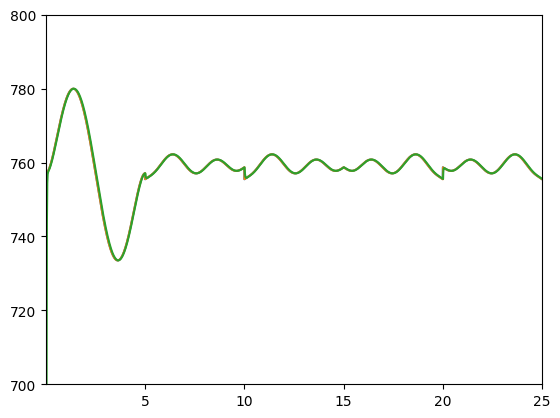

In [131]:
# plt.plot(t, res["xf"].T[:, 13])
plt.plot(t, np.array(u_list)[:, 0])
plt.plot(t, np.array(u_alloc_list)[:, 0])
plt.plot(t, np.array(motor_omega_list)[:, 0])
plt.gca().set_xlim(0.01, 25)
plt.gca().set_ylim(700, 800)

(700.0, 800.0)

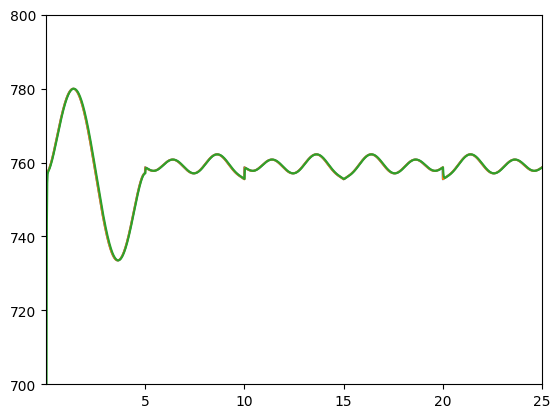

In [132]:
# plt.plot(t, res["xf"].T[:, 13])
plt.plot(t, np.array(u_list)[:, 1])
plt.plot(t, np.array(u_alloc_list)[:, 1])
plt.plot(t, np.array(motor_omega_list)[:, 1])
plt.gca().set_xlim(0.01, 25)
plt.gca().set_ylim(700, 800)

(700.0, 800.0)

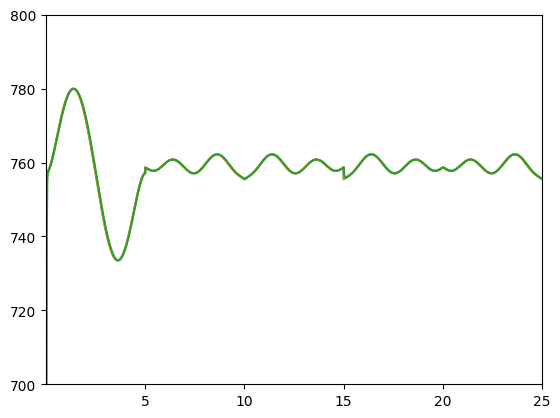

In [133]:
plt.plot(t, np.array(u_list)[:, 2])
plt.plot(t, np.array(u_alloc_list)[:, 2])
plt.plot(t, np.array(motor_omega_list)[:, 2])
plt.gca().set_xlim(0.01, 25)
plt.gca().set_ylim(700, 800)

(700.0, 800.0)

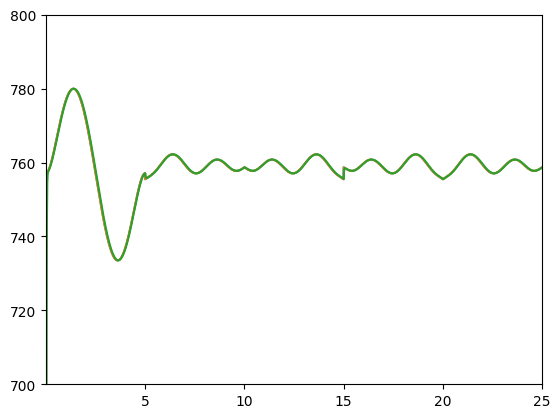

In [134]:
plt.plot(t, np.array(u_list)[:, 3])
plt.plot(t, np.array(u_alloc_list)[:, 3])
plt.plot(t, np.array(motor_omega_list)[:, 3])
plt.gca().set_xlim(0.01, 25)
plt.gca().set_ylim(700, 800)

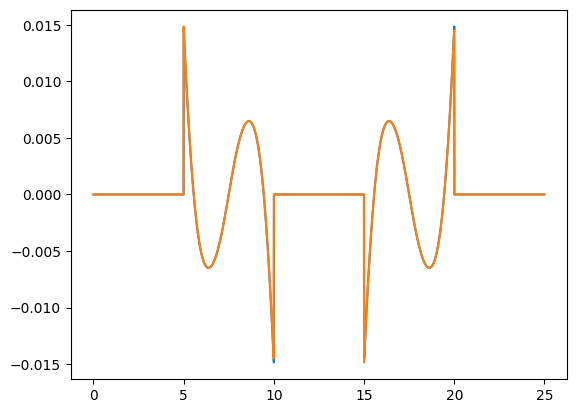

In [112]:
plt.plot(t, np.array(M_ff_list)[:, 0])
plt.plot(t, np.array(M_list)[:, 0])

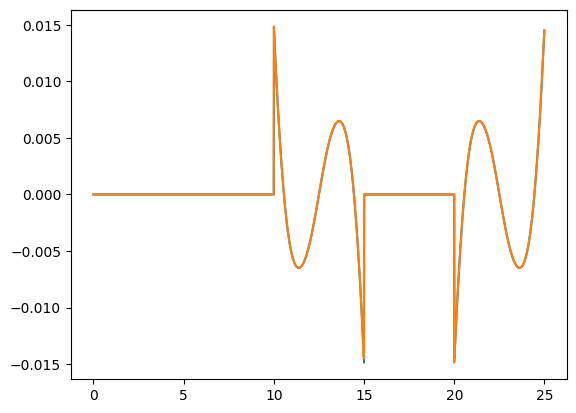

In [113]:
plt.plot(t, np.array(M_ff_list)[:, 1])
plt.plot(t, np.array(M_list)[:, 1])

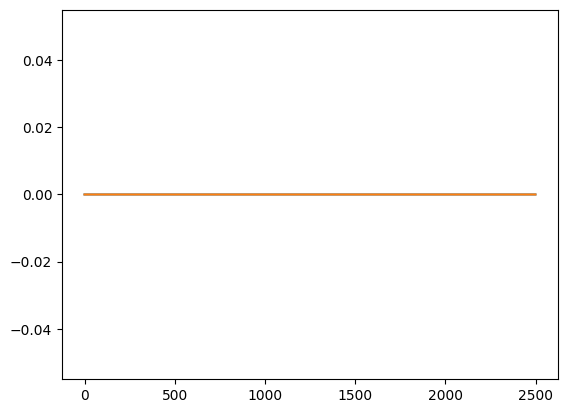

In [114]:
plt.plot(np.array(M_ff_list)[:, 2])
plt.plot(np.array(M_list)[:, 2])

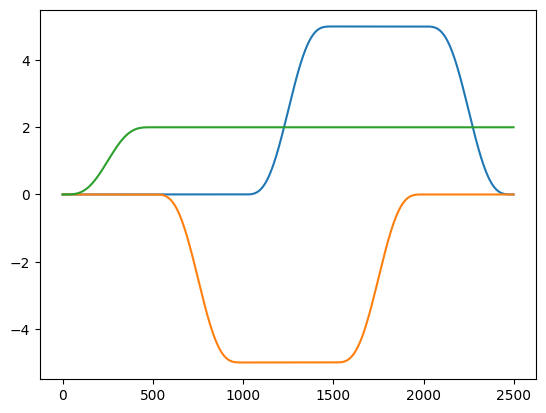

In [115]:
plt.plot(x_sp_list)
plt.plot(y_sp_list)
plt.plot(z_sp_list)

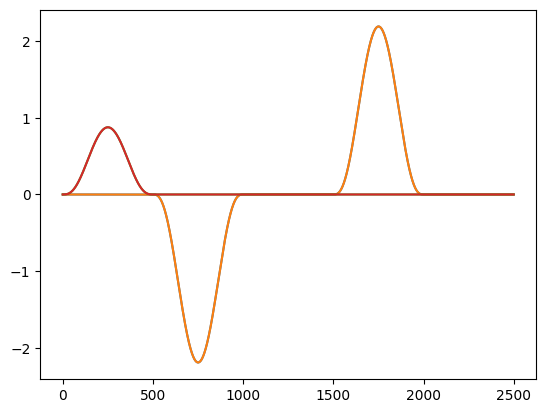

In [116]:
# plt.plot(vx_list)
# plt.plot(np.array(v_sp_list)[:,0])
plt.plot(vy_list)
plt.plot(np.array(v_sp_list)[:, 1])
plt.plot(vz_list)
plt.plot(np.array(v_sp_list)[:, 2])

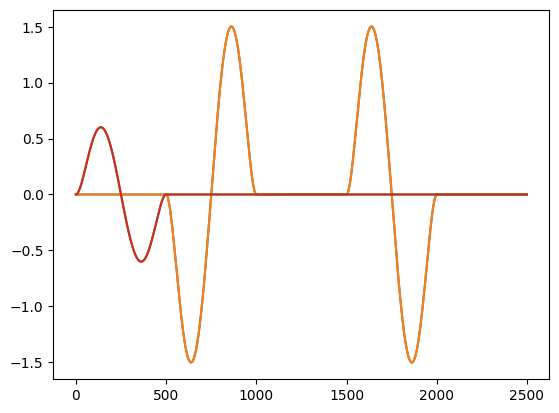

In [117]:
# plt.plot(ax_list)
# plt.plot(np.array(a_sp_list)[:,0])
plt.plot(ay_list)
plt.plot(np.array(a_sp_list)[:, 1])
plt.plot(az_list)
plt.plot(np.array(a_sp_list)[:, 2])

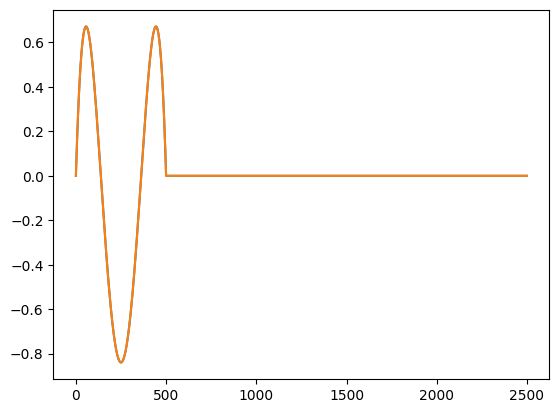

In [118]:
# plt.plot(jx_list)
# plt.plot(np.array(j_sp_list)[:,0])
# plt.plot(jy_list)
# plt.plot(np.array(j_sp_list)[:,1])
plt.plot(jz_list)
plt.plot(np.array(j_sp_list)[:, 2])

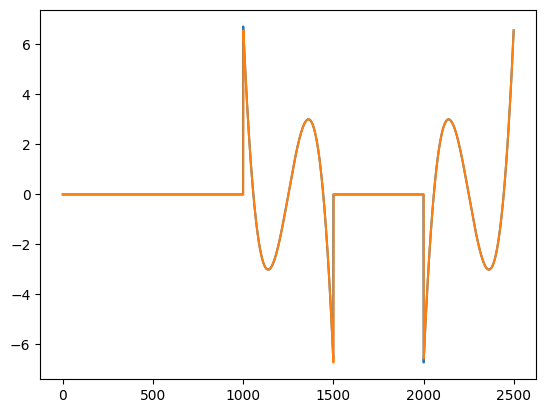

In [119]:
plt.plot(sx_list)
plt.plot(np.array(s_sp_list)[:, 0])
# plt.plot(sy_list)
# plt.plot(np.array(s_sp_list)[:,1])
# plt.plot(sz_list)
# plt.plot(np.array(s_sp_list)[:,2])

In [1]:
from cyecca.lie.group_se2 import SE2
import casadi as ca
import numpy as np

In [22]:
X = SE2.elem(ca.vertcat(1.14, 8.92, -1.2))
Xr = SE2.elem(ca.vertcat(1.5, 8.28, -1.0))

In [23]:
(X.inverse() * Xr).log()

SE2LieAlgebra: SX([0.734892, 0.0305841, 0.2])

In [34]:
Xr = SE2.elem(ca.vertcat(2.78, 2.16, 2.97))
X = SE2.elem(ca.vertcat(2.14, 2.23, 3.03))

In [35]:
(X.inverse() * Xr).log()

SE2LieAlgebra: SX([-0.64357, -0.0210205, -0.06])

In [37]:
X = SE2.elem(ca.vertcat(2.30124, 2.73109, 1.83233))
Xr = SE2.elem(ca.vertcat(2.307, 2.30463, -3.48364))
(X.inverse() * Xr).log()

SE2LieAlgebra: SX([1.8141, -1.62882, -5.31597])

In [36]:
X = SE2.elem(ca.vertcat(2.30124, 2.73109, 1.83233))
Xr = SE2.elem(ca.vertcat(2.307, 2.30463, -3.48364 + 2 * ca.pi))
(X.inverse() * Xr).log()

SE2LieAlgebra: SX([-0.330067, 0.296356, 0.967215])

In [2]:
X = SE2.elem(ca.vertcat(2.38, 2.41507, 2.93781))
Xr = SE2.elem(ca.vertcat(1.8654, 2.3941, -3.293))
(Xr.inverse() * X).log()

SE2LieAlgebra: SX([-0.502859, -0.111564, -0.0523753])

In [3]:
X = SE2.elem(ca.vertcat(2.32706, 2.33248, 2.67962))
Xr = SE2.elem(ca.vertcat(3.08157, 2.20718, -2.93483))
(Xr.inverse() * X).log()

SE2LieAlgebra: SX([0.778751, -0.0287967, -0.668735])

In [5]:
class SE2Lie:
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta

    def to_matrix(self):
        x = self.x
        y = self.y
        theta = self.theta
        cos = np.cos
        sin = np.sin
        return np.array(
            [[cos(theta), -sin(theta), x], [sin(theta), cos(theta), y], [0, 0, 1]]
        )

    @classmethod
    def from_matrix(cls, m):
        theta = np.arctan2(m[1, 0], m[0, 0])
        x = m[0, 2]
        y = m[1, 2]
        return cls(x=x, y=y, theta=theta)

    def __matmul__(self, other):
        return SE2Lie.from_matrix(self.to_matrix() @ other.to_matrix())

    def __repr__(self):
        return "x {:g}: y: {:g} theta: {:g}".format(self.x, self.y, self.theta)

    def log(self):
        x = self.x
        y = self.y
        theta = self.theta
        if np.abs(theta) > 1e-2:
            a = np.sin(theta) / theta
            b = (1 - np.cos(theta)) / theta
        else:
            a = 1 - theta**2 / 6 + theta**4 / 120
            b = theta / 2 - theta**3 / 24 + theta**5 / 720
        V_inv = np.array([[a, b], [-b, a]]) / (a**2 + b**2)
        u = V_inv @ np.array([x, y])
        return SE2Lie(x=u[0], y=u[1], theta=theta)

    def inv(self):
        x = self.x
        y = self.y
        theta = self.theta
        t = -np.array(
            [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
        ) @ np.array([x, y])
        return SE2Lie(x=t[0], y=t[1], theta=-theta)


class se2:
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta

    def to_matrix(self):
        x = self.x
        y = self.y
        theta = self.theta
        return np.array([[0, -theta, x], [theta, 0, y], [0, 0, 0]])

    @classmethod
    def from_matrix(cls, m):
        x = m[0, 2]
        y = m[1, 2]
        theta = m[1, 0]
        return cls(x=x, y=y, theta=theta)

    def __repr__(self):
        return "x {:g}: y: {:g} theta: {:g}".format(self.x, self.y, self.theta)

    def exp(self):
        x = self.x
        y = self.y
        theta = self.theta
        if np.abs(theta) > 1e-2:
            a = np.sin(theta) / theta
            b = (1 - np.cos(theta)) / theta
        else:
            a = 1 - theta**2 / 6 + theta**4 / 120
            b = theta / 2 - theta**3 / 24 + theta**5 / 720
        V = np.array([[a, -b], [b, a]])
        u = V @ np.array([x, y])
        return SE2Lie(x=u[0], y=u[1], theta=theta)

In [12]:
A = SE2Lie(2.32706, 2.33248, 2.67962)
Ar = SE2Lie(3.08157, 2.20718, -2.93483)

In [17]:
A.inv() @ Ar

x -0.731267: y: -0.224131 theta: 0.668735

In [20]:
X.inverse()

SE2LieGroup: SX([1.0435, 3.12518, -2.67962])

In [14]:
SE2.elem(ca.vertcat(-0.50555, -0.098347, 6.23081 - 2 * np.pi)).log()

SE2LieAlgebra: SX([-0.502859, -0.111564, -0.0523753])

In [19]:
(-5.61445 + np.pi) % (2 * np.pi) - np.pi

0.6687353071795865